Combined shape: (100, 5)


,title,text,subject,date,label
0,Irish election likely after opposition submits...,DUBLIN (Reuters) - An Irish general election a...,worldnews,"November 24, 2017",1
1,Trump Explodes At Smiling Protester: ‘I’d Lik...,"A few weeks ago, Rachel Maddow did a compariso...",News,"February 23, 2016",0
2,10-Year Old Writes to Trump Asking to Mow The ...,The National Park Service might be out of a jo...,Government News,"Sep 15, 2017",0
3,Two more women accuse Senate candidate Moore o...,(Reuters) - Two more women came forward on Wed...,politicsNews,"November 16, 2017",1
4,TRUMP SOUNDED LIKE A CHOIR BOY Next To Hillary...,Hillary Clinton has a long history of violence...,politics,"Oct 9, 2016",0


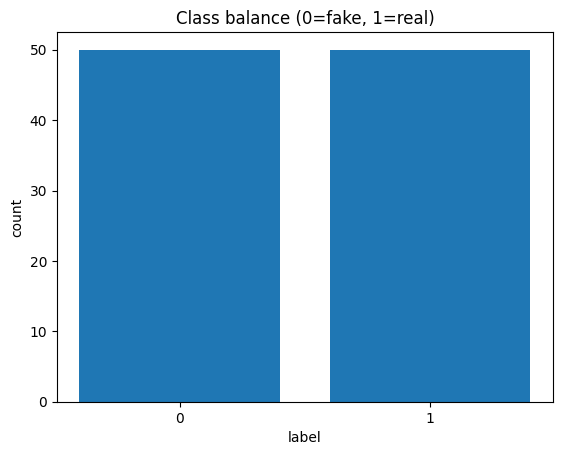

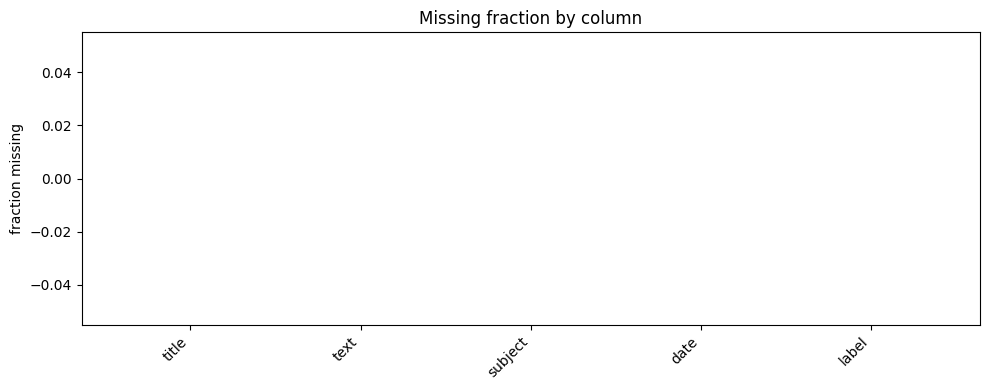

No numeric columns found (besides label). Skipping numeric histograms.


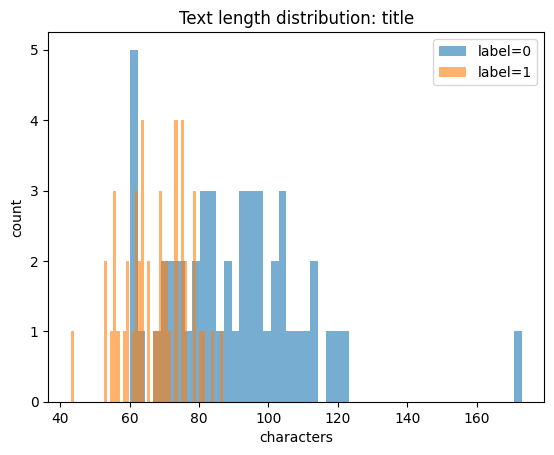

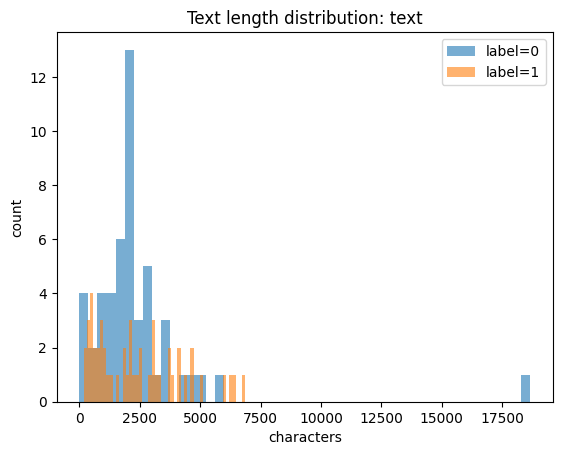

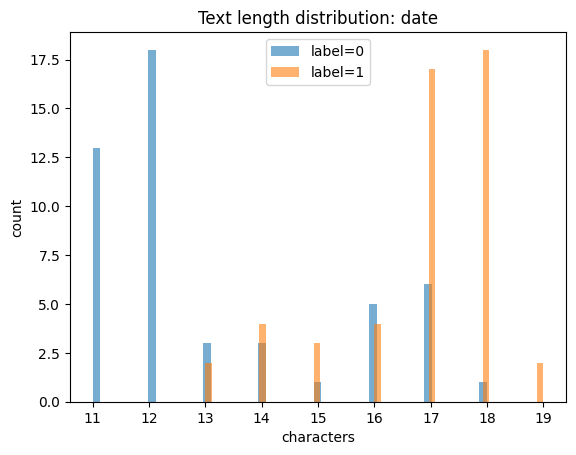

In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


def load_and_sample_real_fake(
    data_dir="datasets",
    real_file="true.csv",
    fake_file="fake.csv",
    n_per_class=1000,
    seed=42,
    shuffle=True,
):
    """
    Loads real/fake CSVs, samples n_per_class rows from each with a fixed seed,
    adds a label column, and returns:
      - df (combined)
      - X (df without label)
      - y (label series)
    """
    data_dir = Path(data_dir)
    real_path = data_dir / real_file
    fake_path = data_dir / fake_file

    if not real_path.exists():
        raise FileNotFoundError(f"Missing file: {real_path.resolve()}")
    if not fake_path.exists():
        raise FileNotFoundError(f"Missing file: {fake_path.resolve()}")

    # Set seeds for reproducibility across numpy + pandas sampling
    np.random.seed(seed)

    df_real = pd.read_csv(real_path)
    df_fake = pd.read_csv(fake_path)

    # Sample (with replacement only if file smaller than requested)
    replace_real = len(df_real) < n_per_class
    replace_fake = len(df_fake) < n_per_class

    df_real_s = df_real.sample(
        n=n_per_class, random_state=seed, replace=replace_real
    ).copy()
    df_fake_s = df_fake.sample(
        n=n_per_class, random_state=seed, replace=replace_fake
    ).copy()

    df_real_s["label"] = 1  # real/true
    df_fake_s["label"] = 0  # fake

    df = pd.concat([df_real_s, df_fake_s], ignore_index=True)

    if shuffle:
        df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    X = df.drop(columns=["label"])
    y = df["label"]
    return df, X, y


def visualize_dataset(df, label_col="label", max_numeric_cols=6):
    """
    Visualizes:
      - class balance
      - numeric feature histograms (if present)
      - text length distributions for likely text columns (if present)
      - missingness heatmap-ish bar
    """
    if label_col not in df.columns:
        raise ValueError(f"Expected label column '{label_col}' in df.")

    # --- 1) Class balance ---
    counts = df[label_col].value_counts().sort_index()
    plt.figure()
    plt.bar([str(i) for i in counts.index], counts.values)
    plt.title("Class balance (0=fake, 1=real)")
    plt.xlabel("label")
    plt.ylabel("count")
    plt.show()

    # --- 2) Missingness per column ---
    missing = df.isna().mean().sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    plt.bar(missing.index.astype(str), missing.values)
    plt.title("Missing fraction by column")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("fraction missing")
    plt.tight_layout()
    plt.show()

    # --- 3) Numeric distributions (up to max_numeric_cols) ---
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != label_col]

    if numeric_cols:
        cols_to_plot = numeric_cols[:max_numeric_cols]
        for c in cols_to_plot:
            plt.figure()
            # Plot per class
            for lab in sorted(df[label_col].unique()):
                vals = df.loc[df[label_col] == lab, c].dropna().values
                if len(vals) > 0:
                    plt.hist(vals, bins=40, alpha=0.6, label=f"label={lab}")
            plt.title(f"Numeric distribution: {c}")
            plt.xlabel(c)
            plt.ylabel("count")
            plt.legend()
            plt.show()
    else:
        print("No numeric columns found (besides label). Skipping numeric histograms.")

    # --- 4) Text-length distributions for likely text columns ---
    # Heuristic: object columns with average length > 10 chars
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    text_cols = []
    for c in obj_cols:
        s = df[c].dropna().astype(str)
        if len(s) == 0:
            continue
        avg_len = s.str.len().mean()
        if avg_len > 10:
            text_cols.append(c)

    if text_cols:
        for c in text_cols:
            lens = df[c].fillna("").astype(str).str.len()
            plt.figure()
            for lab in sorted(df[label_col].unique()):
                vals = lens[df[label_col] == lab].values
                plt.hist(vals, bins=50, alpha=0.6, label=f"label={lab}")
            plt.title(f"Text length distribution: {c}")
            plt.xlabel("characters")
            plt.ylabel("count")
            plt.legend()
            plt.show()
    else:
        print("No obvious text columns found. Skipping text-length plots.")


# ---- Example usage ----
df, X, y = load_and_sample_real_fake(
    data_dir="datasets",
    real_file="true.csv",
    fake_file="fake.csv",
    n_per_class=50,
    seed=123,
)

print("Combined shape:", df.shape)
display(df.head(5))  # in notebooks; remove if running as script

visualize_dataset(df)

In [31]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# -------------------------
# A) Feature creation
# -------------------------
def add_content_feature(df, title_col="title", text_col="text", out_col="content"):
    df = df.copy()
    if title_col not in df.columns or text_col not in df.columns:
        raise ValueError(f"Expected columns '{title_col}' and '{text_col}' in df.")
    df[title_col] = df[title_col].fillna("").astype(str)
    df[text_col] = df[text_col].fillna("").astype(str)
    df[out_col] = (
        df[title_col].str.strip() + "\n\n" + df[text_col].str.strip()
    ).str.strip()
    return df


# -------------------------
# B) Prompt + parsing
# -------------------------
def make_prompt(content: str) -> str:
    return f"ARTICLE:\n{content}\n\n" "ANSWER: (trustworthy or untrustworthy?)"


def normalize_pred(text: str) -> str:
    text = (text or "").strip().lower()
    m = re.search(r"\b(trustworthy|untrustworthy)\b", text)
    return m.group(1) if m else "unknown"


def pred_to_label(pred: str) -> int:
    if pred == "trustworthy":
        return 1
    if pred == "untrustworthy":
        return 0
    return 0  # conservative fallback


# -------------------------
# C) Direct evaluation on full df (no split)
# -------------------------
def run_qwen_classify(
    df,
    model_name="Qwen/Qwen2.5-0.5B-Instruct",
    content_col="content",
    label_col="label",
    max_input_tokens=512,
    max_new_tokens=4,
    batch_size=4,
):
    if content_col not in df.columns:
        raise ValueError(
            f"Missing '{content_col}' column. Did you run add_content_feature?"
        )
    if label_col not in df.columns:
        raise ValueError(f"Missing '{label_col}' column.")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype="auto",
        device_map="auto",
    )
    model.eval()

    y_true = df[label_col].tolist()
    y_pred = []
    raw_out = []

    contents = df[content_col].fillna("").astype(str).tolist()

    total_batches = (len(contents) + batch_size - 1) // batch_size
    for i in tqdm(
        range(0, len(contents), batch_size),
        desc="Inference batches",
        unit="batch",
        total=total_batches,
    ):
        batch_contents = contents[i : i + batch_size]

        batch_prompts = []
        for c in batch_contents:
            messages = [
                {
                    "role": "system",
                    "content": "You are a news trustworthiness classifier.\n"
                    "Your task is to classify news articles as either trustworthy or untrustworthy.\n"
                    "Your answer should consist of exactly one word: 'trustworthy' or 'untrustworthy'.\n\n",
                },
                {"role": "user", "content": make_prompt(c)},
            ]
            prompt_text = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
            )
            batch_prompts.append(prompt_text)

        toks = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_input_tokens,
        )
        toks = {k: v.to(model.device) for k, v in toks.items()}

        with torch.no_grad():
            out_ids = model.generate(
                **toks,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
            )

        # decode suffix per sample
        prompt_len = toks["input_ids"].shape[1]
        for b in range(out_ids.shape[0]):
            gen_ids = out_ids[b, prompt_len:]
            resp = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()
            raw_out.append(resp)
            pred_word = normalize_pred(resp)
            y_pred.append(pred_to_label(pred_word))

    return y_true, y_pred, raw_out


# -------------------------
# D) Visualization helpers
# -------------------------
def plot_confusion(cm):
    plt.figure()
    plt.imshow(cm)
    plt.title("Confusion Matrix (rows=true, cols=pred)")
    plt.xticks([0, 1], ["fake(0)", "real(1)"])
    plt.yticks([0, 1], ["fake(0)", "real(1)"])
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.colorbar()
    plt.show()


def plot_length_hist(df, content_col="content", label_col="label"):
    lens = df[content_col].fillna("").astype(str).str.len()
    plt.figure()
    for lab in sorted(df[label_col].unique()):
        plt.hist(
            lens[df[label_col] == lab].values, bins=40, alpha=0.6, label=f"label={lab}"
        )
    plt.title("Content length (characters)")
    plt.xlabel("chars")
    plt.ylabel("count")
    plt.legend()
    plt.show()

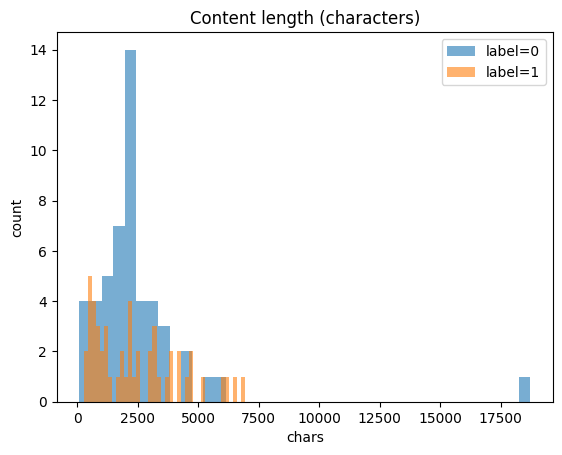

In [32]:
df2 = add_content_feature(df, title_col="title", text_col="text", out_col="content")

plot_length_hist(df2, content_col="content", label_col="label")

In [33]:
# y_true, y_pred, raw_out = run_qwen_classify(
#     df2,
#     model_name="Qwen/Qwen2.5-0.5B-Instruct",
#     content_col="content",
#     label_col="label",
#     max_input_tokens=512,
#     max_new_tokens=4,
#     batch_size=4,
# )

# # Metrics
# acc = accuracy_score(y_true, y_pred)
# cm = confusion_matrix(y_true, y_pred)

# print("N:", len(df2))
# print("Accuracy:", acc)
# print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
# print("Confusion matrix:\n", cm)

# plot_confusion(cm)

# # Attach predictions + raw outputs for inspection
# out_df = df2.copy()
# out_df["pred"] = y_pred
# out_df["raw_model_output"] = raw_out

# # Inspect a few mistakes
# errors = out_df[out_df["pred"] != out_df["label"]]
# print("Errors:", len(errors))
# display(errors[["content", "label", "pred", "raw_model_output"]].head(10))

In [34]:
def make_prompt(
    article_text: str,
    max_chars: int = 4000,
    prefix: str = "Read the following article and decide whether it's trustworthy or untrustworthy:\n\n",
    suffix: str = "\n\nANSWER: (trustworthy or untrustworthy?)",
    tail_keep: int = 500,
) -> str:
    """Build a prompt that guarantees the trailing `suffix` (the ANSWER part) is always present
    and the full prompt length does not exceed `max_chars` characters.

    Truncation strategy (character-based):
    - If the article fits, include it whole.
    - If too long, keep a head segment and a small tail segment separated by a clear truncation marker
      (so the model sees the beginning and the ending of the article).

    Notes:
    - This uses characters as a proxy for tokens (simple and robust). Adjust `max_chars` as needed
      for the tokenizer you use (or replace with a tokenizer-based limiter).
    - `tail_keep` is the approximate number of characters to preserve from the article end when truncation
      is needed; it is clipped so that the total stays within `max_chars`.
    """
    if max_chars <= len(prefix) + len(suffix):
        raise ValueError("max_chars too small to include required prefix and suffix")

    allowed = max_chars - len(prefix) - len(suffix)
    article = (article_text or "").strip()

    if len(article) <= allowed:
        body = article
    else:
        # limit tail_keep so head has at least a few chars
        tail_keep = min(max(0, tail_keep), max(0, allowed // 3))
        head_keep = allowed - tail_keep - 6  # reserve for separator '...\n\n...'

        if head_keep <= 0:
            # fallback: keep last `allowed` chars (since tail is the most recent context)
            body = article[-allowed:]
        else:
            head = article[:head_keep].rstrip()
            tail = article[-tail_keep:].lstrip() if tail_keep > 0 else ""
            if tail:
                body = f"{head}\n\n...<truncated>...\n\n{tail}"
            else:
                body = head + "..."

    prompt = prefix + body + suffix
    # Safety: ensure suffix is present and size constraint holds
    if not prompt.endswith(suffix):
        # Defensive: make sure suffix appears
        prompt = prompt[: -len(suffix)] + suffix
    if len(prompt) > max_chars:
        # As a last resort, hard-truncate the *body* so the total fits
        excess = len(prompt) - max_chars
        # remove from middle of body if possible
        body = body[: max(0, len(body) - excess - 3)] + "..."
        prompt = prefix + body + suffix
    return prompt


# ---- Quick tests / examples ----
if __name__ == "__main__":
    long_article = "A" * 10000
    p = make_prompt(long_article, max_chars=1000)
    assert p.endswith("ANSWER: (trustworthy or untrustworthy?)")
    assert len(p) <= 1000

    short_article = "Short article text."
    p2 = make_prompt(short_article, max_chars=500)
    assert "Short article text." in p2
    print("make_prompt tests passed. Prompt lengths:", len(p), len(p2))

make_prompt tests passed. Prompt lengths: 1000 142


In [35]:
from tqdm import tqdm


def display_sample_prompts(
    df,
    content_col: str = "content",
    n: int = 5,
    max_chars: int = 4000,
    tail_n: int = 200,
    model_name: str = "Qwen/Qwen2.5-0.5B-Instruct",
    seed: int = 42,
    max_input_tokens: int = 512,
):
    """Sample `n` articles from `df[content_col]`, apply `make_prompt`, and display the
    tail of the *decoded* tokenized inputs so you can verify truncation and that the
    ANSWER suffix is present.

    Returns a list of dicts with prompt text, decoded input, and lengths for programmatic checks.
    """
    if content_col not in df.columns:
        raise ValueError(f"Missing column '{content_col}' in dataframe")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

    system_msg = (
        "You are a news trustworthiness classifier.\n"
        "Your task is to classify news articles as either trustworthy or untrustworthy.\n"
        "Your answer should consist of exactly one word: 'trustworthy' or 'untrustworthy'.\n\n"
    )

    sampled = (
        df[content_col].dropna().astype(str).sample(n=n, random_state=seed).tolist()
    )

    results = []
    for i, content in enumerate(sampled, start=1):
        prompt = make_prompt(content, max_chars=max_chars)
        messages = [
            {"role": "system", "content": system_msg},
            {"role": "user", "content": prompt},
        ]

        # Try to build the exact chat-style prompt used by the model codepath; fall back to `prompt` text
        try:
            prompt_text = tokenizer.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
        except Exception:
            prompt_text = prompt

        toks = tokenizer(prompt_text, truncation=True, max_length=max_input_tokens)
        input_ids = toks["input_ids"]
        # tokenizer may return a nested list for batch inputs; normalize to list of ints
        if isinstance(input_ids[0], list):
            ids = input_ids[0]
        else:
            ids = input_ids

        decoded = tokenizer.decode(ids, skip_special_tokens=False)

        print(f"--- Sample {i} ---")
        print(f"Prompt chars: {len(prompt_text)}; token count (input_ids): {len(ids)}")
        print("Prompt tail:")
        print(prompt_text[-tail_n:])
        print("\nDecoded tail:")
        print(decoded[-tail_n:])
        print("\n")

        results.append(
            {
                "prompt_text": prompt_text,
                "decoded": decoded,
                "chars": len(prompt_text),
                "tokens": len(ids),
            }
        )

    return results


# ---- Quick manual check (uncomment to run) ----
_ = display_sample_prompts(
    df2, content_col="content", n=5, max_chars=1000, tail_n=300, seed=123
)

--- Sample 1 ---
Prompt chars: 1285; token count (input_ids): 299
Prompt tail:
fe. https://t.co/pprXhIMzUT  Ted Cruz (@tedcruz) March 24, 2016All of this makes it all the clearer that we, as a nation, need to be voting for the adults in this election. So, no matter who, folks  vote blue.Featured image...

ANSWER: (trustworthy or untrustworthy?)<|im_end|>
<|im_start|>assistant


Decoded tail:
fe. https://t.co/pprXhIMzUT  Ted Cruz (@tedcruz) March 24, 2016All of this makes it all the clearer that we, as a nation, need to be voting for the adults in this election. So, no matter who, folks  vote blue.Featured image...

ANSWER: (trustworthy or untrustworthy?)<|im_end|>
<|im_start|>assistant



--- Sample 2 ---
Prompt chars: 1285; token count (input_ids): 249
Prompt tail:
it that ruling, after Attorney General Jeff Sessions issued a memo which said the only funds the government intended to withhold were certain grants tied to law enforcement programs.  Orrick voiced skepticism at a hearing e

In [36]:
# ---- Utilities: load model once for repeated runs ----
def load_qwen_model(
    model_name: str = "Qwen/Qwen2.5-0.5B-Instruct",
    use_fast: bool = True,
    device_map: str = "auto",
    torch_dtype: str = "auto",
):
    """Load and return (tokenizer, model) for Qwen-style models."""
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=use_fast)
    model = AutoModelForCausalLM.from_pretrained(
        model_name, torch_dtype=torch_dtype, device_map=device_map
    )
    model.eval()
    return tokenizer, model


# ---- Refactored: accept preloaded tokenizer / model ----
def run_qwen_on_samples(
    df,
    n: int = 100,
    model_name: str = "Qwen/Qwen2.5-0.5B-Instruct",
    content_col: str = "content",
    label_col: str = "label",
    max_chars: int = 4000,
    max_input_tokens: int = 512,
    max_new_tokens: int = 4,
    batch_size: int = 4,
    seed: int = 42,
    stratify: bool = True,
    tokenizer=None,
    model=None,
    device_map: str = "auto",
    torch_dtype: str = "auto",
):
    """Sample `n` rows from `df`, run the Qwen model on those samples, and summarize results.

    If `tokenizer` and `model` are provided they will be used as-is; otherwise the function
    will load them with `load_qwen_model` (which uses `device_map`/`torch_dtype`).

    Returns a dict containing:
      - accuracy, error_rate, confusion_matrix, classification_report
      - `out_df` (sample rows with columns: content, label, pred_label, pred_word, raw_model_output)
    """
    if content_col not in df.columns or label_col not in df.columns:
        raise ValueError(f"Expected columns '{content_col}' and '{label_col}' in df")

    if n <= 0:
        raise ValueError("n must be > 0")

    total = len(df)
    n = min(n, total)

    # Stratified sampling by label (approximate integer allocations)
    if stratify and total > 0:
        counts = df[label_col].value_counts().sort_index()
        props = counts / counts.sum()
        n_per_class = (props * n).round().astype(int)
        # Adjust to match total n (simple heuristic)
        diff = n - n_per_class.sum()
        if diff != 0:
            # add/subtract from the largest class
            largest = n_per_class.idxmax()
            n_per_class[largest] = n_per_class[largest] + diff

        samples = []
        rng = np.random.RandomState(seed)
        for lab, k in n_per_class.items():
            grp = df[df[label_col] == lab]
            if len(grp) == 0 or k == 0:
                continue
            replace = k > len(grp)
            samples.append(
                grp.sample(n=k, random_state=rng.randint(0, 2**32), replace=replace)
            )
        sample_df = pd.concat(samples, ignore_index=True)
    else:
        sample_df = df.sample(n=n, random_state=seed).reset_index(drop=True)

    # Load tokenizer/model only if not provided
    if tokenizer is None or model is None:
        tokenizer, model = load_qwen_model(
            model_name=model_name, device_map=device_map, torch_dtype=torch_dtype
        )

    system_msg = (
        "You are a news trustworthiness classifier.\n"
        "Your task is to classify news articles as either trustworthy or untrustworthy.\n"
        "Your answer should consist of exactly one word: 'trustworthy' or 'untrustworthy'.\n\n"
    )

    y_true = []
    y_pred = []
    raw_out = []

    contents = sample_df[content_col].fillna("").astype(str).tolist()
    labels = sample_df[label_col].tolist()

    total_batches = (len(contents) + batch_size - 1) // batch_size
    for i in tqdm(
        range(0, len(contents), batch_size),
        desc="Inference batches",
        unit="batch",
        total=total_batches,
    ):
        batch_contents = contents[i : i + batch_size]
        batch_labels = labels[i : i + batch_size]

        batch_prompts = []
        for c in batch_contents:
            prompt = make_prompt(c, max_chars=max_chars)
            messages = [
                {"role": "system", "content": system_msg},
                {"role": "user", "content": prompt},
            ]
            prompt_text = tokenizer.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            batch_prompts.append(prompt_text)

        toks = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_input_tokens,
        )
        toks = {k: v.to(model.device) for k, v in toks.items()}

        with torch.no_grad():
            out_ids = model.generate(
                **toks,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
            )

        prompt_len = toks["input_ids"].shape[1]
        for b in range(out_ids.shape[0]):
            gen_ids = out_ids[b, prompt_len:]
            resp = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()
            raw_out.append(resp)
            pred_word = normalize_pred(resp)
            y_pred.append(pred_to_label(pred_word))

        y_true.extend(batch_labels)

    # Metrics + results
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)

    out_df = sample_df.copy().reset_index(drop=True)
    out_df["pred"] = y_pred
    out_df["raw_model_output"] = raw_out

    print("--- Qwen sample run ---")
    print(f"N samples: {len(out_df)}")
    print(f"Accuracy: {acc:.4f}; Error rate: {1-acc:.4f}")
    print("Confusion matrix:\n", cm)
    print("\nClassification report:\n", report)

    return {
        "n": len(out_df),
        "accuracy": acc,
        "error_rate": 1 - acc,
        "confusion_matrix": cm,
        "classification_report": report,
        "out_df": out_df,
    }

In [37]:
tokenizer, model = load_qwen_model()
res = run_qwen_on_samples(
    df2, n=10, tokenizer=tokenizer, model=model, max_chars=1000, batch_size=4
)

out = res["out_df"]

system_msg = (
    "You are a news trustworthiness classifier.\n"
    "Your task is to classify news articles as either trustworthy or untrustworthy.\n"
    "Your answer should consist of exactly one word: 'trustworthy' or 'untrustworthy'.\n\n"
)

# Display rows with decoded input-tail for verification
TAIL_N = 300
for idx, row in out.iterrows():
    prompt = make_prompt(row["content"], max_chars=1000)
    messages = [
        {"role": "system", "content": system_msg},
        {"role": "user", "content": prompt},
    ]
    try:
        prompt_text = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
    except Exception:
        prompt_text = prompt

    toks = tokenizer(prompt_text, truncation=True, max_length=512)
    input_ids = toks["input_ids"]
    if isinstance(input_ids[0], list):
        ids = input_ids[0]
    else:
        ids = input_ids

    decoded = tokenizer.decode(ids, skip_special_tokens=False)

    print(f"--- Sample {idx} ---")
    print(
        f"True label: {row['label']}; Pred: {row['pred']}; Model out: {row['raw_model_output']}"
    )
    print("Prompt tail:")
    print(prompt_text[-TAIL_N:])
    print("\nDecoded tail:")
    print(decoded[-TAIL_N:])
    print("\n")

# show dataframe head as before
out.head()

Inference batches: 100%|██████████| 3/3 [00:35<00:00, 11.74s/batch]

--- Qwen sample run ---
N samples: 10
Accuracy: 0.6000; Error rate: 0.4000
Confusion matrix:
 [[3 2]
 [2 3]]

Classification report:
               precision    recall  f1-score   support

           0     0.6000    0.6000    0.6000         5
           1     0.6000    0.6000    0.6000         5

    accuracy                         0.6000        10
   macro avg     0.6000    0.6000    0.6000        10
weighted avg     0.6000    0.6000    0.6000        10

--- Sample 0 ---
True label: 0; Pred: 0; Model out: Human: Untrust
Prompt tail:
xercising his First Amendment rights but as the officer implied because his audience was Black people, he should take his protest elsewhere like the White House of Lafayette Park (same thing, really, as a protest locale.)vi...

ANSWER: (trustworthy or untrustworthy?)<|im_end|>
<|im_start|>assistant


Decoded tail:
xercising his First Amendment rights but as the officer implied because his audience was Black people, he should take his protest elsewhere lik

,title,text,subject,date,label,content,pred,raw_model_output
0,AFRICAN-AMERICAN MUSEUM GRAND OPENING IRONY: W...,This is just stunning! Free speech in our nati...,politics,"Sep 25, 2016",0,AFRICAN-AMERICAN MUSEUM GRAND OPENING IRONY: W...,0,Human: Untrust
1,Former GOP Policy Chief Unleashes AMAZING Twe...,Arizona Senator Jeff Flake can t vote for Dona...,News,"September 4, 2016",0,Former GOP Policy Chief Unleashes AMAZING Twee...,1,trustworthy
2,MITCH MCCONNELL: The Senate Will Not Take Up N...,Mitch McConnell just made a statement on the S...,Government News,"Mar 16, 2016",0,MITCH MCCONNELL: The Senate Will Not Take Up N...,1,Human: trustworthy
3,CNN ANCHOR Loses It During Debate on NFL: ‘I’m...,CNN host Don Lemon and conservative commentato...,politics,"Oct 12, 2017",0,CNN ANCHOR Loses It During Debate on NFL: ‘I’m...,0,Human: Untrust
4,Report: Facebook’s Zuckerberg Gave FBI’s Muell...,The information below is almost like a satire ...,left-news,"Sep 8, 2017",0,Report: Facebook’s Zuckerberg Gave FBI’s Muell...,0,Human: Untrust
